In [22]:
#load model
#load data
# create new dataset which has more information (country, number of genes etc)
# run a 1 epoch no batching training
# extract the CLS 
#PCA --> Plotting 

import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchtext
import torchtext.vocab as vocab
from pathlib import Path
import os
import re
from copy import deepcopy


from data_preprocessing import data_loader, data_original
from build_vocabulary import vocab_geno
from build_vocabulary import vocab_pheno
from bert_builder import BERT
from misc import get_paths
from misc import model_loader

############################
model_name = '2024-04-08modelEnc4Emb512Mask0.3ModeTrueNOPT.pt'
load_directory = "D://Models//0804CLSEXP2//"

load_state = load_directory + model_name
hyperparameters = re.findall('[A-Z][^A-Z]*', model_name)
numbers = []
for i in range (len(hyperparameters)):
    numbers.append(re.findall('\d+', hyperparameters[i]))

parameters = [int(num) for sublist in numbers for num in sublist if num]


num_enc = parameters[0]
dim_emb = parameters[1]
dim_hidden = parameters[1]
mask_prob = 0

########################
threshold_year = 1970
max_length = [51,44]
mask_prob = 0.15
drop_prob = 0.2
reduced_samples = 1000 

attention_heads = 4 

include_pheno = True   
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#############################

base_dir = Path(os.path.abspath(''))
os.chdir(base_dir)
data_dir, ab_dir, save_directory = get_paths()

print(f"\n Retrieving data from: {data_dir}")
print("Loading data...")
NCBI,ab_df = data_loader(include_pheno,threshold_year,data_dir,ab_dir)
NCBI_geno_only = data_original(threshold_year,data_dir, ab_dir)
print(f"Data correctly loaded, {len(NCBI)} samples found")
print("Creating vocabulary...")
vocabulary_geno = vocab_geno(NCBI_geno_only)
vocabulary_pheno = vocab_pheno(ab_df)

class CLSDataset(Dataset):

    MASKED_INDICES_COLUMN = 'masked_indices'
    TOKEN_MASK_COLUMN = 'token_mask'
    NUM_GENES = 'num_genes'
    NUM_ABS = 'num_abs'
    LOCATIONS = 'locations'
    ABCLASSES = 'num_abClasses'

    def __init__(self,
                 data: pd.DataFrame,
                 vocab_geno: vocab,
                 vocab_pheno: vocab,
                 max_seq_len: list,
                 mask_prob: float,
                 dim_emb: int,
                 include_pheno:bool,
                 random_state: int = 23,
                 ):
        
        self.random_state = random_state
        np.random.seed(self.random_state)

        CLS = '[CLS]'
        PAD = '[PAD]'
        MASK = '[MASK]'
        UNK = '[UNK]'

        self.include_pheno = include_pheno
        self.data = data.reset_index(drop=True) 
        self.num_samples = self.data.shape[0]
        self.vocab_geno = vocab_geno
        self.vocab_pheno = vocab_pheno
        self.dim_emb = dim_emb  
        self.vocab_size_geno = len(self.vocab_geno)
        self.CLS = CLS 
        self.PAD = PAD
        self.MASK = MASK
        self.UNK = UNK
        self.max_seq_len = max_seq_len
        self.mask_prob = mask_prob

        self.columns = [self.MASKED_INDICES_COLUMN, self.TOKEN_MASK_COLUMN, self.NUM_GENES, self.NUM_ABS, self.LOCATIONS, self.ABCLASSES]


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.df.iloc[idx]
        input = torch.tensor(item[self.MASKED_INDICES_COLUMN],device=device).long()
        attention_mask = (input == self.vocab_geno[self.PAD]).unsqueeze(0)
        num_genes = torch.tensor(item[self.NUM_GENES], device=device).long()
        num_abs = torch.tensor(item[self.NUM_ABS], device=device).long()
        locations = torch.tensor(item[self.LOCATIONS], device=device).long()
        AbClasses = torch.tensor(item[self.ABCLASSES], device=device).long()

        return input, attention_mask, num_genes, num_abs, locations, AbClasses


    def _construct_masking(self):
        sequences = deepcopy(self.data['genes'].tolist())
        masked_sequences = []
        target_indices_list = []
        seq_starts = [[self.CLS, self.data['year'].iloc[i], self.data['location'].iloc[i]] for i in range(self.data.shape[0])]

        for i, geno_seq in enumerate(sequences):
            seq_len = len(geno_seq)
            masking_index = np.random.rand(seq_len) < self.mask_prob   
            target_indices = np.array([-1]*seq_len)
            indices = masking_index.nonzero()[0]
            target_indices[indices] = self.vocab_geno.lookup_indices([geno_seq[i] for i in indices])
            for i in indices:
                r = np.random.rand()
                if r < 0.8:
                    geno_seq[i] = self.MASK
                elif r > 0.9:
                    geno_seq[i] = self.vocab_geno.lookup_token(np.random.randint(self.vocab_size_geno))
            geno_seq = seq_starts[i] + geno_seq
            target_indices = [-1]*3 + target_indices.tolist() 
            masked_sequences.append(geno_seq)
            target_indices_list.append(target_indices)
        masked_sequences = [seq + [self.PAD]*(self.max_seq_len[0] - len(seq)) for seq in masked_sequences]
        for i in range(len(target_indices_list)):
            indices = target_indices_list[i]
            padding = [-1] * (self.max_seq_len[0] - len(indices))
            target_indices_list[i] = indices + padding
        return masked_sequences, target_indices_list 
    
    def _num_tested(self):
        ab_sequences = deepcopy(self.data['AST_phenotypes'].tolist())
        gene_sequences = deepcopy(self.data['genes'].tolist())
        num_genes = []
        num_abs = []
        for i in range(len(gene_sequences)):
            current_gene_seq = gene_sequences[i]
            current_ab_seq = ab_sequences[i]

            num_genes.append(len(current_gene_seq))
            num_abs.append(len(current_ab_seq))
        
        return num_genes, num_abs
    
    def _location(self):
        location = deepcopy(self.data['location'].tolist())
        locations = []
        for i in range(len(location)):
            current_location = location[i]

            locations.append(self.vocab_geno.lookup_indices([current_location]))
        
        return locations
    
    def _numAbClasses(self):
        antibiotic_classes = {
            'amoxicillinclavulanicacid': 'Penicillins',
            'ampicillin': 'Penicillins',
            'aztreonam': 'Monobactams',
            'cefazolin': 'Cephalosporins',
            'cefepime': 'Cephalosporins',
            'cefotaxime': 'Cephalosporins',
            'cefoxitin': 'Cephalosporins',
            'cefpodoxime': 'Cephalosporins',
            'ceftazidime': 'Cephalosporins',
            'ceftriaxone': 'Cephalosporins',
            'chloramphenicol': 'Others',
            'ciprofloxacin': 'Quinolones',
            'ertapenem': 'Carbapenems',
            'gentamicin': 'Aminoglycosides',
            'imipenem': 'Carbapenems',
            'levofloxacin': 'Quinolones',
            'meropenem': 'Carbapenems',
            'streptomycin': 'Aminoglycosides',
            'sulfamethoxazole': 'Sulfonamides',
            'sulfisoxazole': 'Sulfonamides',
            'tetracycline': 'Tetracyclines',
            'tobramycin': 'Aminoglycosides',
            'trimethoprim': 'Sulfonamides',
            'trimethoprimsulfamethoxazole': 'Sulfonamides'
        }
        Abs = deepcopy(self.data['AST_phenotypes'].tolist())
        NumAB = []
        for i, seq in enumerate(Abs):
            classes = set()
            for antibiotic_list in seq:
                for antibiotic_name in antibiotic_list.split(', '):
                    antibiotic_name = antibiotic_name.split('=')[0]
                    if antibiotic_name in antibiotic_classes:
                        classes.add(antibiotic_classes[antibiotic_name])
            NumAB.append(len(classes))
        return NumAB
    
    def prepare_dataset(self):
        masked_sequences, target_indices = self._construct_masking()
        indices_masked = [self.vocab_geno.lookup_indices(masked_seq) for masked_seq in masked_sequences]
        num_genes, num_abs = self._num_tested()
        locations = self._location()  
        num_abClasses = self._numAbClasses()

        rows = zip(indices_masked, target_indices, num_genes,num_abs, locations, num_abClasses)
        self.df = pd.DataFrame(rows, columns=self.columns)

dataset = CLSDataset(NCBI, vocabulary_geno, vocabulary_pheno, max_length, mask_prob, dim_emb, include_pheno)
dataset.prepare_dataset()
print("Dataset correctly prepared.")

df = pd.DataFrame(columns=[f"col_{i}" for i in range(dim_emb)])
model = BERT(vocab_size=len(vocabulary_geno), dim_embedding = dim_emb, dim_hidden=dim_hidden, attention_heads=8, num_encoders=num_enc, dropout_prob=drop_prob, num_ab=len(vocabulary_pheno), cls_mode=True, device=device).to(device)

cls_mode = True
model = model_loader(load_state,vocabulary_geno, vocabulary_pheno, dim_emb, dim_hidden, num_enc, drop_prob, cls_mode, device)

for i in range(len(dataset)):
    cls_s = model(dataset[i][0], dataset[i][1]) 
    cls_s = cls_s.tolist()
    df.loc[i] = cls_s
num_genes = []
num_ab = []
locations = []
for i in range(len(dataset)):
    num_genes.append(dataset[i][2].item())
    num_ab.append(dataset[i][3].item())
    locations.append(dataset[i][4].item())
df['num_genes'] = num_genes
df['num_abs'] = num_ab
df['locations'] = locations

######################################



c:\Users\erika\Desktop\Exjobb\repo\base

 Retrieving data from: c:\Users\erika\Desktop\Exjobb\data
Loading data...
Data correctly loaded, 6486 samples found
Creating vocabulary...
Dataset correctly prepared.
Loading model from D://Models//0804CLSEXP2//2024-04-08modelEnc4Emb512Mask0.3ModeTrueNOPT.pt


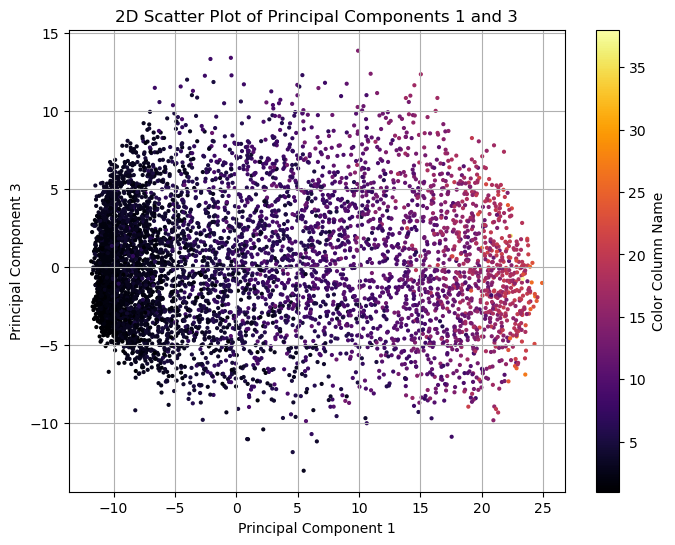

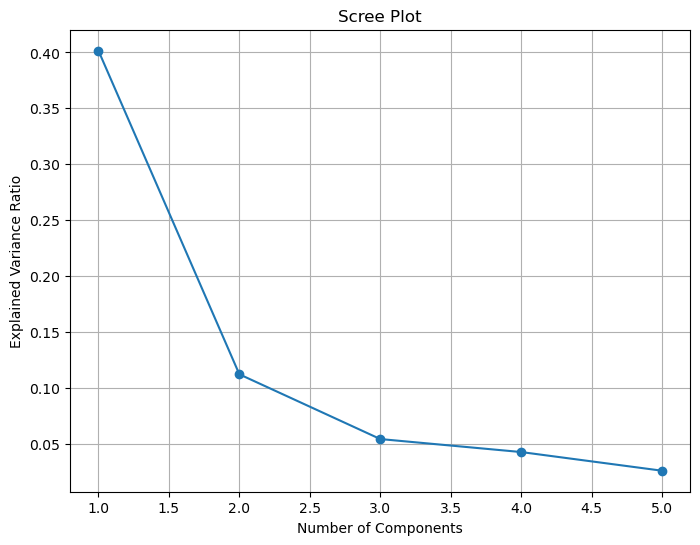

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

components = [1,3]

pca = PCA(n_components=5)
principalComponents = pca.fit_transform(df.iloc[:,:-3])
explained_variance_ratio = pca.explained_variance_ratio_

# Select the specified components
selected_components = [component - 1 for component in components]  # Convert to 0-based indexing
principalDf = pd.DataFrame(data=principalComponents[:, selected_components], 
                           columns=[f'principal component {c}' for c in components])

plt.figure(figsize=(8, 6))
scatter = plt.scatter(principalDf[f'principal component {components[0]}'], 
                      principalDf[f'principal component {components[1]}'], 
                      c=df['num_genes'], cmap='inferno', s=4)  

plt.title(f'2D Scatter Plot of Principal Components {components[0]} and {components[1]}')
plt.xlabel(f'Principal Component {components[0]}')
plt.ylabel(f'Principal Component {components[1]}')
plt.grid(True)

# Add color bar
plt.colorbar(scatter, label='Color Column Name')

plt.show()

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

